In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


In [2]:
df = pd.read_csv("mpd_sp500.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# drop columns that has "maturity_target" , "lg_change_decr", and "lg_change_incr" in the column name; those are irrelevant for feature selection
df = df[df.columns.drop(list(df.filter(regex='maturity_target')))]
df = df[df.columns.drop(list(df.filter(regex='lg_change_decr')))]
df = df[df.columns.drop(list(df.filter(regex='lg_change_incr')))]
df = df[df.columns.drop(list(df.filter(regex='SP_adj_close')))]

# drop SP_lg_ret(%)	
df = df.drop(['SP_lg_ret(%)'], axis=1)
# df = df.drop(['SP_lg_pr'], axis=1)
df = df.drop(['VIX'], axis=1)

# Generate lagged variables from f1_mu to SP_lg_pr
lags = 6
for lag in range(1, lags+1):
    # for col in df.columns[df.columns.get_loc('f1_mu'):df.columns.get_loc('SP_lg_ret_vol')+1]:
    # for col in df.columns[df.columns.get_loc('f1_mu'):df.columns.get_loc('VIX')+1]: 
    for col in df.columns[df.columns.get_loc('f1_mu'):df.columns.get_loc('SP_lg_pr')+1]: 
    # for col in df.columns[df.columns.get_loc('f1_mu'):df.columns.get_loc('SP_lg_ret(%)')+1]:    
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

df_lagged = df.copy()
# drop NA rows
df_lagged = df_lagged.dropna()
df_lagged.shape



# Define the target variable
start_colunm = df_lagged.columns.get_loc('f1_mu_lag1')
# end_column = df_lagged.columns.get_loc('VIX_lag6')
end_column = df_lagged.columns.get_loc('SP_lg_pr_lag6')
# end_column = df_lagged.columns.get_loc('SP_lg_ret(%)_lag6')

column_index = list(range(start_colunm, end_column+1))

X = df_lagged.iloc[:, column_index]
# y = df_lagged['SP_lg_ret(%)'] 
y = df_lagged['SP_lg_pr'] 

split_index = int(len(X)*0.75)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

/var/folders/57/dq27lfpd1zb7kzzggckgkm2h0000gn/T/ipykernel_30127/709878160.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{lag}'] = df[col].shift(lag)
/var/folders/57/dq27lfpd1zb7kzzggckgkm2h0000gn/T/ipykernel_30127/709878160.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{lag}'] = df[col].shift(lag)
/var/folders/57/dq27lfpd1zb7kzzggckgkm2h0000gn/T/ipykernel_30127/709878160.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((428, 762), (143, 762), (428,), (143,))

In [4]:
# pred_lg_pr = pd.read_csv("Predicted_SP_lg_pr.csv")

pred_lg_pr = pd.read_csv("Rolling_Predicted_SP_lg_pr.csv")



In [5]:
# reset index for pred_lg_pr using the same index as y_test
pred_lg_pr = pred_lg_pr.set_index(y_test.index)
Backtest = X_test.copy()
Backtest['True_Lg_Price'] = y_test
Backtest['Predicted_Lg_Price'] = pred_lg_pr

In [6]:
# keep only the last two columns of Backtest
Backtest = Backtest[['True_Lg_Price', 'Predicted_Lg_Price']]

Backtest['True_Lg_Return'] = Backtest['True_Lg_Price'] - Backtest['True_Lg_Price'].shift(1)
Backtest['Predicted_Lg_Return'] = Backtest['Predicted_Lg_Price'] - Backtest['Predicted_Lg_Price'].shift(1)

# # if log return is positive, then 1; otherwise, 0
# Backtest['True_Return_Sign'] = np.where(Backtest['True_Lg_Return'] > 0, 1, 0)
# Backtest['Predicted_Sign'] = np.where(Backtest['Predicted_Lg_Return'] > 0, 1, 0)


因为我们用的都是lag1到lag9的数据，说明我们用这这些数据来预测下周的log price的情况
所以我们在同步与mpd数据的周频率来设置为我们买卖SP的时间，我们在频率周的第一天开盘时间enter position， 在频率周最后一天的收盘前决定是否exit position或者进行持仓。

In [7]:
# read the SP500 price data
SP500 = pd.read_csv("^SPX.csv")
SP500['Date'] = pd.to_datetime(SP500['Date'])
SP500.set_index('Date', inplace=True)


# # if log return is positive, then 1; otherwise, 0
# Backtest['True_Return_Sign'] = np.where(Backtest['True_Lg_Return'] > 0, 1, 0)
# Backtest['Predicted_Sign'] = np.where(Backtest['Predicted_Lg_Return'] > 0, 1, 0)

# Calculate the percentage change for the trading signal
# Backtest['True_Lg_Return_Shifted'] = Backtest['True_Lg_Return'].shift(1)
Backtest['Perc_Change'] = ((Backtest['Predicted_Lg_Return'] - Backtest['True_Lg_Return'].shift(1)) / Backtest['Predicted_Lg_Return']) * 100

# Define trading signal based on the percentage change
# Using 1 for Long, 0 for Short, and -1 for Hold
Backtest['Predicted_Return_Sign'] = np.where(Backtest['Perc_Change'] > 5, 1, np.where(Backtest['Perc_Change'] < -5, 0, -1))


start_date = Backtest.index[0]
end_date = Backtest.index[-1]
print(start_date, end_date)

# select SP500 price data between start_date and end_date
SP500 = SP500.loc[start_date:end_date]

# merge SP500 price data to Backtest
Combined = Backtest.merge(SP500, how='right', left_index=True, right_index=True)

2021-05-19 00:00:00 2024-02-07 00:00:00


In [8]:
# drop columns of High, Low, Close, and Volume
Final = Combined.drop(['Perc_Change','High', 'Low', 'Open', 'Adj Close', 'Volume'], axis=1)



In [9]:
# # # Forward fill Predicted_Lg_Return and columns
# # Combined['Predicted_Lg_Return'] = Combined['Predicted_Lg_Return'].ffill()
# # Combined['Predicted_Return_Sign'] = Combined['Predicted_Sign'].ffill()

# # Backward fill Predicted_Lg_Return and columns
# # Combined['Predicted_Lg_Return'] = Combined['Predicted_Lg_Return'].bfill()
# # Combined['Predicted_Return_Sign'] = Combined['Predicted_Sign'].bfill()

# Final = Combined.drop(['True_Lg_Return', 'True_Return_Sign', 'True_Lg_Return_Shifted', 'Predicted_Sign', 'Adj Close'], axis=1)

# # reoroder the columns
# # Final = Final[['True_Lg_Price',	'Predicted_Lg_Price', 'Predicted_Lg_Return', 'Predicted_Return_Sign', 'Close']]

# Final.head(20)

In [10]:
# drop NA rows expect the first row
Final2 = Final.iloc[[0]].append(Final.iloc[1:].dropna())
Final2.head(20)

/var/folders/57/dq27lfpd1zb7kzzggckgkm2h0000gn/T/ipykernel_30127/1143550365.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Final2 = Final.iloc[[0]].append(Final.iloc[1:].dropna())


,True_Lg_Price,Predicted_Lg_Price,True_Lg_Return,Predicted_Lg_Return,Predicted_Return_Sign,Close
Date,,,,,,
2021-05-19,8.322559,8.303837,NaN,NaN,-1.0,4115.680176
2021-05-26,8.341885,8.314411,0.019325,0.010574,-1.0,4195.990234
2021-06-02,8.344771,8.334829,0.002887,0.020418,1.0,4208.120117
2021-06-09,8.347484,8.339413,0.002712,0.004584,1.0,4219.549805
2021-06-16,8.348467,8.340361,0.000983,0.000948,0.0,4223.700195
2021-06-23,8.352752,8.340716,0.004286,0.000355,0.0,4241.839844
2021-06-30,8.365789,8.344679,0.013036,0.003963,0.0,4297.500000
2021-07-07,8.379798,8.356788,0.014010,0.012109,0.0,4358.129883
2021-07-14,8.383502,8.370084,0.003703,0.013296,0.0,4374.299805


In [11]:
# Final2.to_csv("Signal_List2.csv")

In [12]:
Final2.shape

(143, 6)

In [13]:
# 20天 
# SMA, 20天移动平均线
# EMA, 20天指数移动平均线
# MACD, 12天指数移动平均线 - 26天指数移动平均线


In [14]:
Final2.tail(20)

,True_Lg_Price,Predicted_Lg_Price,True_Lg_Return,Predicted_Lg_Return,Predicted_Return_Sign,Close
Date,,,,,,
2023-09-27,8.360425,8.388599,-0.029435,-0.013110,0.0,4274.509766
2023-10-04,8.357904,8.360590,-0.002520,-0.028009,0.0,4263.750000
2023-10-11,8.384107,8.355859,0.026203,-0.004731,1.0,4376.950195
2023-10-18,8.369760,8.381072,-0.014348,0.025213,-1.0,4314.600098
2023-10-25,8.339685,8.370994,-0.030075,-0.010078,0.0,4186.770020
2023-11-01,8.351814,8.341536,0.012129,-0.029458,-1.0,4237.859863
2023-11-08,8.385438,8.350643,0.033625,0.009107,0.0,4382.779785
2023-11-15,8.412472,8.383437,0.027034,0.032794,-1.0,4502.879883
2023-11-22,8.424336,8.409211,0.011864,0.025773,-1.0,4556.620117


### Backtest

In [15]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [16]:
# initialize parameters
initial_balance = 10000000  # initial balance
# margin_ratio = 0.1  # margin ratio
commission_rate = 0.001  # transaction fee
# contract_multiplier = 100  # contract multiplier of futures
# balance_usage_ratio = 0.1  # balance usage ratio

# balance_usage_ratio / margin_ratio = leverage_ratio

trade_times = 0
right_times = 0
accumulated_earnings = 0
accumulated_losses = 0

# initialize account information
current_balance = initial_balance
# frozen_balance = 0
open_positions = {'Direction':'No_Position'}  # current position records
order_records = []  # order records 
account_values = []  # account values record

In [17]:
# # Update the signal calculation function to reverse the signal indications
# def calculate_signal(data):
#     data_copy = data.copy()  
#     if data_copy['Predicted_Return_Sign'].iloc[-1] == 0.0:
#         return "Long"  # Now indicates a "Long" signal when the last value is 0.0
#     elif data_copy['Predicted_Return_Sign'].iloc[-1] == 1.0:
#         if 0.0 in data_copy['Predicted_Return_Sign'].values:
#             return "Short"  # Now indicates a "Short" signal when the last value is 1.0 and there's a later 0.0
#         else:
#             return "No_Signal_Update"  # If there are no later 0.0, keep it as "No_Signal_Update"
#     else:
#         return "No_Signal_Update"

In [18]:
# Update the signal calculation function to consider future signals
def calculate_signal(data):
    data_copy = data.copy()  
    if data_copy['Predicted_Return_Sign'].iloc[-1] == 1.0:
        return "Long"
    elif data_copy['Predicted_Return_Sign'].iloc[-1] == -1.0:
        if 1.0 in data_copy['Predicted_Return_Sign'].values:
            return "Short"  # If there is a later 1.0, consider the current -1.0 as "Short"
        else:
            return "No_Signal_Update"  # If there are no later 1.0, keep it as "No_Signal_Update"
    else:
        return "No_Signal_Update"

In [19]:
# # Update the signal calculation function to consider future signals
# def calculate_signal(data):
#     data_copy = data.copy()  
#     if data_copy['Predicted_Return_Sign'].iloc[-1] == 1.0:
#         return "Long"
#     elif data_copy['Predicted_Return_Sign'].iloc[-1] == 0.0:
#         if 1.0 in data_copy['Predicted_Return_Sign'].values:
#             return "Short"  # If there is a later 1.0, consider the current 0.0 as "Short"
#         else:
#             return "No_Signal_Update"  # If there are no later 1.0, keep it as "No_Signal_Update"
#     else:
#         return "No_Signal_Update"

In [20]:
def open_position(window_data, signal):
    global current_balance, open_positions, order_records, trade_times, right_times, accumulated_earnings, accumulated_losses

    latest_price = window_data['Close'].iloc[-2]
    position_size = math.floor(current_balance / latest_price)


    open_positions = {
        'Symbol': 'SP500',
        'PositionSize':position_size,
        'AveragePrice':latest_price, 
        'Direction':signal
    }

    order_records.append({
        'DateTime':window_data.index[-1], 
        'Action':'Open_Position', 
        'Symbol': 'SP500',
        'Price':latest_price, 
        'Direction':signal
    })

In [21]:
def close_position(window_data):
    global current_balance, open_positions, order_records, trade_times, right_times, accumulated_earnings, accumulated_losses

    latest_price = window_data['Close'].iloc[-1]

    if open_positions['Direction'] == "Long":
        profit_loss = (window_data['Close'].iloc[-1] - open_positions['AveragePrice']) * open_positions['PositionSize']
        profit_loss -= commission_rate * open_positions['PositionSize'] * window_data['Close'].iloc[-1]
    elif open_positions['Direction'] == "Short":
        profit_loss = (open_positions['AveragePrice'] - window_data['Close'].iloc[-1]) * open_positions['PositionSize']
        profit_loss -= commission_rate * open_positions['PositionSize'] * window_data['Close'].iloc[-1]
    else:
        profit_loss = 0

    current_balance += profit_loss

    open_positions = {
        'Symbol': 'SP500',
        'PositionSize': 0,
        'AveragePrice':  0,
        'Direction': 'No_Position'
    }

    order_records.append({
        'DateTime':window_data.index[-1], 
        'Action':'Close_Position', 
        'Symbol': 'SP500',
        'Price':latest_price, 
        'Quantity':open_positions['PositionSize'],
        'ProfitLoss':profit_loss,
        'Direction':open_positions['Direction']
    })


    if profit_loss > 0:
        right_times += 1
        accumulated_earnings += profit_loss
    else:
        accumulated_losses += profit_loss
    
    trade_times += 1

In [22]:
# def plot_account_values(df):

#     datetime = np.array(df['DateTime'])
#     net_balance = np.array(df['NetBalance'])
#     net_price = np.array(df['NetPrice'])
#     direction = np.array(df['Direction'])

#     fig, ax = plt.subplots()

#     # plot NetBalance and NetPrice curves
#     ax.plot(datetime, net_balance, label='Strategy Return (SR))', color='black', linewidth=0.7 )
#     ax.plot(datetime, net_price, label='SP Return (SP)', color='blue', linewidth=0.7)

#     # note the last value of NetBalance and NetPrice
#     last_balance = np.array(df['StrategyReturn'])[-1]
#     last_price = np.array(df['SPReturn'])[-1]
#     # ax.text(0.98, 0.95, f'Current NAB: {last_balance:.2f}\nCurrent NAP: {last_price:.2f}',
#     #         transform=ax.transAxes, color='black', ha='right', va='top', fontsize=10)
#     # label the last balance value on the plot
#     plt.annotate(f'Current SR {last_balance:.2f}', 
#              (df['DateTime'].iloc[-1], df['NetBalance'].iloc[-1]), 
#              xytext=(-10, -10), textcoords='offset points', 
#              ha='right', va='top', fontsize=10,
#              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

#     plt.annotate(f'Current SP: {last_price:.2f}', 
#              (df['DateTime'].iloc[-1], df['NetPrice'].iloc[-1]), 
#              xytext=(-10, -10), textcoords='offset points', 
#              ha='right', va='top', fontsize=10,
#              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

def plot_account_values(df):

    datetime = df.index  # Use the DataFrame's index directly
    net_balance = np.array(df['NetBalance'])
    net_price = np.array(df['NetPrice'])
    direction = np.array(df['Direction'])

    fig, ax = plt.subplots()

    # plot NetBalance and NetPrice curves
    ax.plot(datetime, net_balance, label='Strategy Return (SR))', color='black', linewidth=0.7 )
    ax.plot(datetime, net_price, label='SP Return (SP)', color='blue', linewidth=0.7)

    # Adjust annotations and other datetime-related operations to use 'datetime' directly
    # For example:
    plt.annotate(f'Current SR {net_balance[-1]:.2f}', 
             (datetime[-1], net_balance[-1]), 
             xytext=(-10, -10), textcoords='offset points', 
             ha='right', va='top', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    plt.annotate(f'Current SP: {net_price[-1]:.2f}', 
             (datetime[-1], net_price[-1]), 
             xytext=(-10, -10), textcoords='offset points', 
             ha='right', va='top', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    # fill the area between NetBalance and NetPrice curves
    for i in range(len(datetime)):
        if direction[i] == 1:
            rect = mpatches.Rectangle((datetime[i], ax.get_ylim()[0]),
                                      width=pd.Timedelta(minutes=1), height=ax.get_ylim()[1],
                                      color='red', alpha=0.03)
            ax.add_patch(rect)
        elif direction[i] == 0:
            rect = mpatches.Rectangle((datetime[i], ax.get_ylim()[0]),
                                      width=pd.Timedelta(minutes=1), height=ax.get_ylim()[1],
                                      color='green', alpha=0.03)
            ax.add_patch(rect)

    ax.xaxis_date()
    fig.autofmt_xdate()
    ax.set_title('Strategy Return and SP Return Over Time\nred:Long position  green:Short position  Other:No position')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.legend(loc='upper left')
    

In [23]:
def strategy_evaluation(df, trade_times, right_times):
    # Ensure 'df.index' is of datetime type. This is crucial for plotting and calculations that involve dates.
    # If 'df.index' is not a datetime index, you should convert it before this function or within this function using:
    # df.index = pd.to_datetime(df.index)

    datetime = df.index  # This assumes 'df.index' is already a datetime type.

    evaluation_table = pd.DataFrame()

    # Calculate strategy return
    trading_strategy_return = df['StrategyReturn'].iloc[-1]
    gold_return = df['SP500_Return'].iloc[-1]
    evaluation_table.loc['Strategy Return', 'Value'] = round(trading_strategy_return, 3)

    # Calculate annualized return
    net_value = df['NetBalance'].iloc[-1] / df['NetBalance'].iloc[0]
    gold_net_value = df['NetPrice'].iloc[-1] / df['NetPrice'].iloc[0]
    annual_return = net_value ** (252 / len(df)) - 1
    gold_annual_return = gold_net_value ** (252 / len(df)) - 1
    evaluation_table.loc['Strategy Annualized Return', 'Value'] = round(annual_return, 3)

    evaluation_table.loc['SP500 Return', 'Value'] = round(gold_return, 3)
    evaluation_table.loc['SP500 Annualized Return', 'Value'] = round(gold_annual_return, 3)

    # Calculate excess return
    excess_return = df['NetBalance'].iloc[-1] - df['NetPrice'].iloc[-1]
    evaluation_table.loc['Excess Return', 'Value'] = round(excess_return, 3)

    daily_returns = df['NetBalance'].pct_change()
    volatility = daily_returns.std() * np.sqrt(252)
    evaluation_table.loc['Volatility', 'Value'] = round(volatility, 3)

    risk_free_rate = 0.03
    sharpe_ratio = (annual_return - risk_free_rate) / volatility
    evaluation_table.loc['Sharpe Ratio', 'Value'] = round(sharpe_ratio, 3)

    df['max_Drawdown'] = df['NetBalance'] / df['NetBalance'].cummax() - 1
    drawdown = df['max_Drawdown'].min()
    evaluation_table.loc['Max Drawdown', 'Value'] = round(drawdown, 3)

    evaluation_table.loc['Trade Times', 'Value'] = trade_times
    win_rate = round(right_times / trade_times, 3) if trade_times > 0 else 0
    evaluation_table.loc['Win Rate', 'Value'] = win_rate

    if right_times == 0:
        profit_loss_ratio = 0
    elif (trade_times - right_times) == 0:
        profit_loss_ratio = (accumulated_earnings / right_times)
    else:
        profit_loss_ratio = (accumulated_earnings / right_times) / (-accumulated_losses / (trade_times - right_times))
    evaluation_table.loc['Profit/Loss Ratio', 'Value'] = round(abs(profit_loss_ratio), 3)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(datetime, df['StrategyReturn'], label='Strategy Return')
    plt.title('Strategy Return Curve')
    plt.annotate(f'Current StrategyReturn: {trading_strategy_return:.2f}', 
                 (datetime[-1], df['StrategyReturn'].iloc[-1]), 
                 xytext=(-10, -10), textcoords='offset points', 
                 ha='right', va='top', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(datetime, df['max_Drawdown'], label='Max Drawdown')
    plt.title('Max Drawdown Curve')
    plt.annotate(f'Max Drawdown: {drawdown:.2f}', 
                 (datetime[-1], df['max_Drawdown'].iloc[-1]), 
                 xytext=(-10, -10), textcoords='offset points', 
                 ha='right', va='top', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    plt.legend()

    plt.figure(figsize=(10, 5))
    plt.axis('off')  
    plt.table(cellText=evaluation_table.reset_index().values,
              colLabels=['Metric', 'Value'],
              cellLoc='center',
              loc='center')
    plt.title('Strategy Evaluation Table')

    # Uncomment the next line if you want to display the plots when the function is called
    # plt.show()
    
    return evaluation_table, df
   

In [24]:
# def strategy_evaluation(df, trade_times, right_times):
    
#     datetime = df.index  # Use the DataFrame's index directly
#     evaluation_table = pd.DataFrame()

#     # calculate strategy return

#     trading_strategy_return = df['StrategyReturn'].iloc[-1]
#     gold_return = df['SPReturn'].iloc[-1]
#     evaluation_table.loc['Strategy Return', 'Value'] = round(trading_strategy_return, 3)

#     # calculate annualized return
#     # len(df['NetBalance']) 11894 trading_days 17104
#     #start_date = df['DateTime'].iloc[0]
#     #end_date = df['DateTime'].iloc[-1]
#     #trading_days = (end_date - start_date).days
#     net_value = df['NetBalance'].iloc[-1] / df['NetBalance'].iloc[0]
#     gold_net_value = df['NetPrice'].iloc[-1] / df['NetPrice'].iloc[0]
#     annual_return = net_value ** (252 / len(df)) - 1
#     gold_annual_return = gold_net_value ** (252 / len(df)) - 1
#     evaluation_table.loc['Strategy Annualized Return', 'Value'] = round(annual_return, 3)
#     #benchmark_annualized_return = round((round(df['NetPrice'].iloc[-1], 3) / df['NetPrice'].iloc[0]) ** (252 / len(df_account_values)) - 1, 3) 

#     evaluation_table.loc['SP500 Return', 'Value'] = round(gold_return, 3)
#     evaluation_table.loc['SP500 Annualized Return', 'Value'] = round(gold_annual_return, 3)

#     # calculate excess return: need to choose the benchmark, here is relative to the gold future price
#     excess_return = df['NetBalance'].iloc[-1] - df['NetPrice'].iloc[-1]
#     evaluation_table.loc['Excess Return', 'Value'] = round(excess_return, 3)

 
#     daily_returns = df['NetBalance'].pct_change() 
#     volatility = daily_returns.std() * np.sqrt(252)  
#     evaluation_table.loc['Volatility', 'Value'] = round(volatility, 3)


#     risk_free_rate = 0.03  
#     sharpe_ratio = (annual_return - risk_free_rate) / volatility
#     evaluation_table.loc['Sharpe Ratio', 'Value'] = round(sharpe_ratio, 3)

    
#     df['max_Drawdown'] = df['NetBalance'] / df['NetBalance'].cummax() - 1
    
#     drawdown = df['max_Drawdown'].min()
#     evaluation_table.loc['Max Drawdown', 'Value'] = round(drawdown, 3)

#     evaluation_table.loc['Trade Times', 'Value'] = round(trade_times)

#     win_rate = round(right_times / trade_times, 3)
#     evaluation_table.loc['Win Rate', 'Value'] = win_rate

#     if right_times == 0:
#         profit_loss_ratio = 0 
#     elif (trade_times-right_times) == 0:
#         profit_loss_ratio = (accumulated_earnings/right_times)
#     else:
#         profit_loss_ratio = (accumulated_earnings/right_times) / (accumulated_losses/(trade_times-right_times))
#     evaluation_table.loc['Profit/Loss Ratio', 'Value'] = round(abs(profit_loss_ratio), 3)


#     plt.figure(figsize=(12, 6))
#     plt.subplot(2, 1, 1)

#     ####
#     # plt.plot(df['DateTime'].to_numpy(), df['NetBalance'].to_numpy(), label='Strategy Net Value')
#     # plt.title('Strategy NetBalance Curve')

#     ###

#     plt.plot(df['DateTime'].to_numpy(), df['StrategyReturn'].to_numpy(), label='Strategy Return')
#     plt.title('Strategy Return Curve')

#     # note the last value of NetBalance
#     last_balance = df['StrategyReturn'].iloc[-1]
#     # label the last balance value on the plot
#     # plt.text(df['DateTime'].iloc[-1], df['NetBalance'].iloc[-1], f'Current NetBalance: {last_balance:.2f}',
#     #          color='black', ha='right', va='bottom', fontsize=10)
#     plt.annotate(f'Current StrategyReturn: {last_balance:.2f}', 
#              (df['DateTime'].iloc[-1], df['NetBalance'].iloc[-1]), 
#              xytext=(-10, -10), textcoords='offset points', 
#              ha='right', va='top', fontsize=10,
#              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
#     plt.legend()

#     plt.subplot(2, 1, 2)
#     plt.plot(df['DateTime'].to_numpy(), df['max_Drawdown'].to_numpy(), label='Max Drawdown')
#     plt.title('Max Drawdown Curve')
#     # lable the max drawdown value on the plot
#     # plt.text(df['DateTime'].iloc[-1], df_account_values['Drawdown'].iloc[-1], f'Max Drawdown: {drawdown:.2f}',
#     #          color='black', ha='right', va='bottom', fontsize=10)

#     plt.annotate(f'Max Drawdown: {drawdown:.2f}', 
#                  (df['DateTime'].iloc[-1], df['max_Drawdown'].iloc[-1]), 
#                  xytext=(-10, -10), textcoords='offset points', 
#                  ha='right', va='top', fontsize=10,
#                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))


#     plt.legend()


#     plt.figure(figsize=(10, 5))
#     plt.axis('off')  
#     plt.table(cellText=evaluation_table.reset_index().values,
#               colLabels=['Metric', 'Value'],
#               cellLoc='center',
#               loc='center')
#     plt.title('Strategy Evaluation Table')

#     #plt.show()
    
#     return evaluation_table, df



In [25]:
for i in range(len(Final)):
    window_data = Final.iloc[:i+1]
    signal = calculate_signal(window_data)
    if signal == "Long" and open_positions['Direction'] == "No_Position":
        open_position(window_data, signal)
    elif signal == "Short" and open_positions['Direction'] == "Long":
        # Close the long position if a short signal is received, instead of opening a short position
        close_position(window_data)
    # Removed the condition to open a short position
    else:
        pass

    latest_price = window_data['Close'].iloc[-1]

    if open_positions['Direction'] == "Long":
        profit_loss = (latest_price - open_positions['AveragePrice']) * open_positions['PositionSize']
    elif open_positions['Direction'] == "Short":
        profit_loss = (open_positions['AveragePrice'] - latest_price) * open_positions['PositionSize']
    else:
        profit_loss = 0
    
    total_balance = current_balance + profit_loss

    account_values.append({
        'DateTime':window_data.index[-1],
        'TotalBalance':total_balance,
        'CurrentBalance':current_balance,
        'ProfitLoss':profit_loss,
        'LatestPrice':latest_price,
        'Direction':open_positions['Direction'],
        'NetBalance':round(total_balance/initial_balance,2),
        'NetPrice':round(latest_price/window_data['Close'].iloc[0],2),
        'StrategyReturn':round(total_balance/initial_balance-1,2),
        'SP500_Return':round(latest_price/window_data['Close'].iloc[0]-1,2)
    })


    if current_balance + profit_loss < 0:
        close_position(window_data)

In [26]:
df_account_values = pd.DataFrame(account_values)
df_account_values.set_index('DateTime', inplace=True)
df_account_values.to_csv("Account_Values4.csv")

In [27]:
df_account_values.head()

,TotalBalance,CurrentBalance,ProfitLoss,LatestPrice,Direction,NetBalance,NetPrice,StrategyReturn,SP500_Return
DateTime,,,,,,,,,
2021-05-19,10000000.0,10000000.0,0.0,4115.680176,No_Position,1.0,1.00,0.0,0.00
2021-05-20,10000000.0,10000000.0,0.0,4159.120117,No_Position,1.0,1.01,0.0,0.01
2021-05-21,10000000.0,10000000.0,0.0,4155.859863,No_Position,1.0,1.01,0.0,0.01
2021-05-24,10000000.0,10000000.0,0.0,4197.049805,No_Position,1.0,1.02,0.0,0.02
2021-05-25,10000000.0,10000000.0,0.0,4188.129883,No_Position,1.0,1.02,0.0,0.02


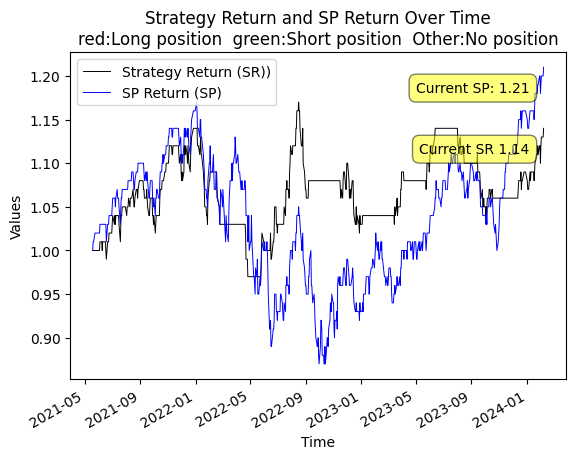

In [28]:
plot_account_values(df_account_values)


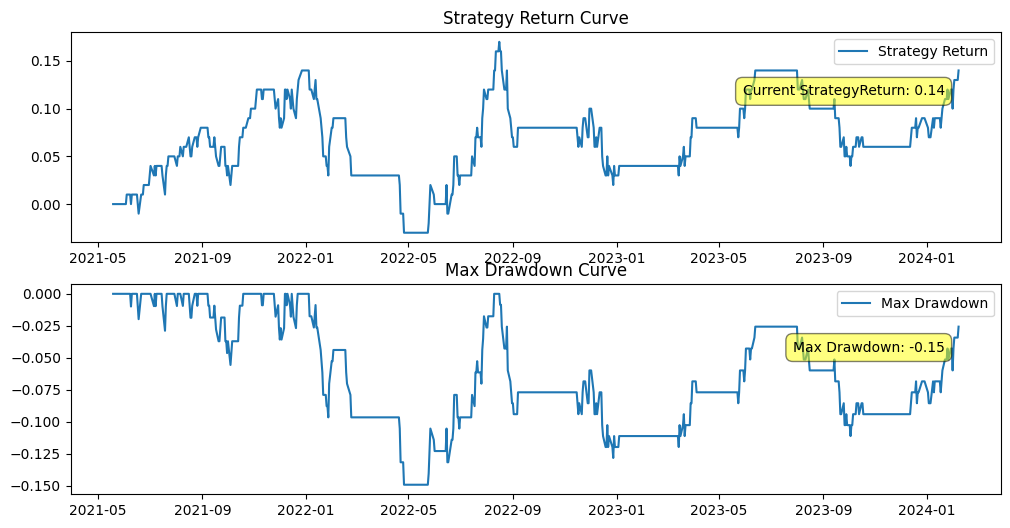

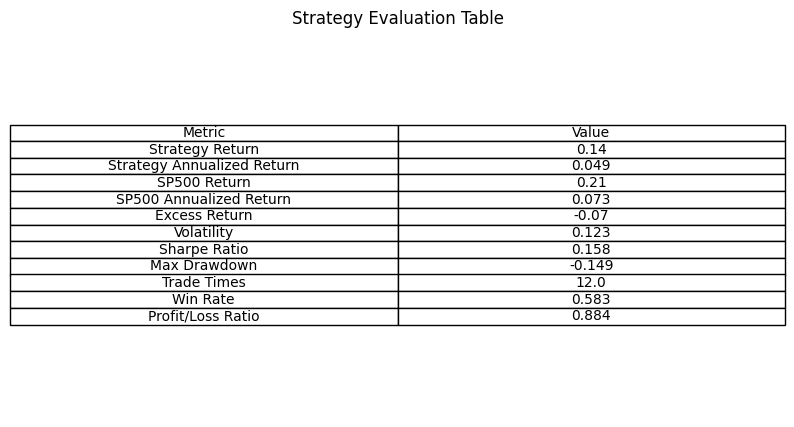

In [29]:
# Assuming df_account_values is correctly structured and includes a 'DateTime' index
_, df_strat_evalue = strategy_evaluation(df_account_values, trade_times, right_times)

# Convert index to 'DateTime' if it's not already a column
df_strat_evalue['DateTime'] = df_strat_evalue.index if 'DateTime' not in df_strat_evalue.columns else df_strat_evalue['DateTime']

# Ensure 'max_Drawdown' exists in df_strat_evalue
if 'max_Drawdown' not in df_strat_evalue.columns:
    # You need to calculate or ensure max_Drawdown is correctly populated in df_strat_evalue
    pass  # Placeholder for actual calculation or correction

# Now, proceed with your original intention
df_strat_evalue['Year'] = df_strat_evalue['DateTime'].dt.year
df_strat_evalue['MaxDrawdown'] = df_strat_evalue.groupby('Year')['max_Drawdown'].transform('min')

In [30]:
# # Create a table with the year and the corresponding maximum drawdown
# drawdown_table = df_strat_evalue.groupby('Year')['MaxDrawdown'].min().reset_index()
# drawdown_table